In [1]:
import os
import copy
import json
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, NBeats, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
job_id = "3dcgyav" # os.environ["job_id"]
data_path = f"/code/data/{job_id}"

with open(os.path.join(data_path, "data.json"), "r", encoding="UTF-8") as f:
    data = json.load(f)

with open(os.path.join(data_path, "config.json"), "r", encoding="UTF-8") as c:
    config = json.load(c)

In [3]:
df = pd.read_json(data, orient="key")
df["date"] = pd.to_datetime(df["date"])

In [4]:
df.head()

,date,last_price,start_price,high_price,low_price,volume
0,2021-01-04,83000,81000,84400,80200,38655276
1,2021-01-05,83900,81600,83900,81600,35335669
2,2021-01-06,82200,83300,84500,82100,42089013
3,2021-01-07,82900,82800,84200,82700,32644642
4,2021-01-08,88800,83300,90000,83000,59013307


In [5]:
config

{'model_name': 'TFT',
 'valid_rate': 0.8,
 'input_window': 3,
 'output_window': 1,
 'job_id': '3dcgyav'}

In [6]:
# full_dates = pd.date_range(start=df.date[0], end=df.date[df.shape[0]-1])
# date_df = pd.DataFrame({"date": full_dates, "time_idx":range(len(full_dates))})
# new_df = pd.merge(left = df , right = date_df, how = "inner", on = "date")

new_df = df.copy()
new_df["group"] = 1
new_df["time_idx"] = range(new_df.shape[0])
new_df["dayofweek"] = list(map(str, new_df['date'].dt.dayofweek))
new_df = new_df.astype({"last_price":"float", "start_price":"float", "high_price":"float", "low_price":"float", "volume":"float"}) 
# new_df["last_price2"] =new_df["last_price"]/1000000

new_df = new_df[["last_price", "group", "time_idx"]]

In [7]:
context_length = 10 # config["input_window"]
prediction_length = 3 # config["output_window"]
print((context_length, prediction_length))

training_cutoff = new_df["time_idx"].max() - prediction_length
training = TimeSeriesDataSet(
    new_df[lambda x: x.time_idx < training_cutoff],
    time_idx="time_idx",
    target="last_price",
    categorical_encoders={"group": NaNLabelEncoder().fit(new_df.group)},
    group_ids=["group"],
    time_varying_unknown_reals=["last_price"], #["last_price", "start_price","high_price", "low_price", "volume"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    allow_missing_timesteps=True,
    add_target_scales=False,
)


(10, 3)


In [8]:
print(training_cutoff)
validation = TimeSeriesDataSet.from_dataset(training, new_df, min_prediction_idx=training_cutoff)

244


In [11]:
batch_size = 2
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

In [12]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    gradient_clip_val=0.1,
    weights_summary="top",
    callbacks=[early_stop_callback],
    limit_train_batches=15,
)

net = NBeats.from_dataset(
    training, 
    learning_rate=3e-2, 
    log_interval=10, 
    log_val_interval=1, 
    log_gradient_flow=False, 
    weight_decay=1e-2, 
    backcast_loss_ratio=1.0,
)
print(f"Number of parameters in network: {net.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 1605.1k


In [13]:
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.6 M 
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.420     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:413: UserWarning: The number of training samples (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 0:  94%|█████████▍| 15/16 [00:10<00:00,  1.50it/s, loss=4.27, v_num=2, train_loss_step=1.920]
Validating: 0it [00:00, ?it/s]
Epoch 1:  94%|█████████▍| 15/16 [00:10<00:00,  1.38it/s, loss=2.08, v_num=2, train_loss_step=2.010, val_loss=2.050, train_loss_epoch=4.250]
Validating: 0it [00:00, ?it/s]
Epoch 2:  94%|█████████▍| 15/16 [00:10<00:00,  1.39it/s, loss=1.92, v_num=2, train_loss_step=2.490, val_loss=1.660, train_loss_epoch=2.130]
Validating: 0it [00:00, ?it/s]
Epoch 3:  94%|█████████▍| 15/16 [00:10<00:00,  1.37it/s, loss=1.67, v_num=2, train_loss_step=1.180, val_loss=1.940, train_loss_epoch=1.900]
Validating: 0it [00:00, ?it/s]
Epoch 4:  94%|█████████▍| 15/16 [00:10<00:00,  1.40it/s, loss=1.81, v_num=2, train_loss_step=0.862, val_loss=1.170, train_loss_epoch=1.600]
Validating: 0it [00:00, ?it/s]
Epoch 5:  94%|█████████▍| 15/16 [00:10<00:00,  1.42it/s, loss=2.1, v_num=2, train_loss_step=2.180, val_loss=1.850, train_loss_epoch=2.050] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  94%|

In [14]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [15]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(1407.5455)

In [16]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

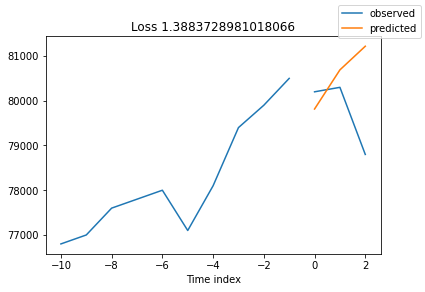

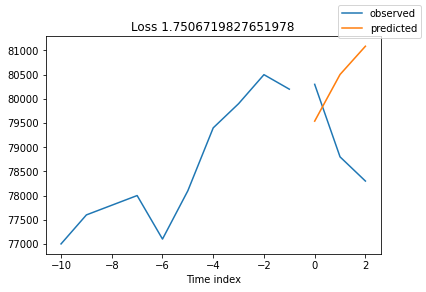

In [17]:
for idx in range(10):
    try:
        best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);
    except:
        break

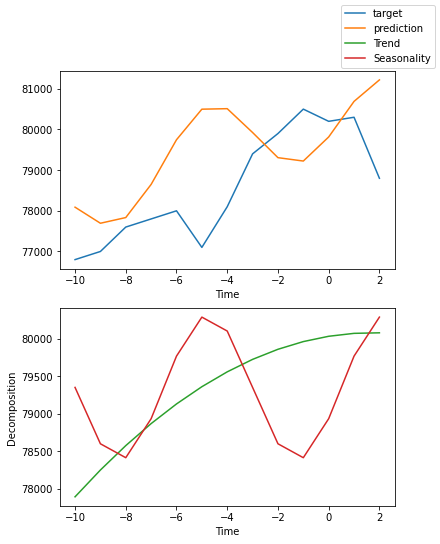

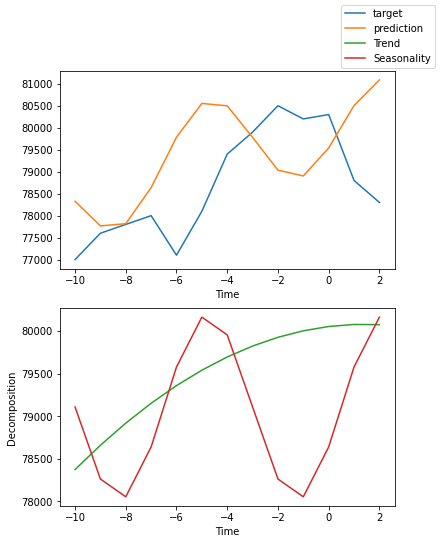

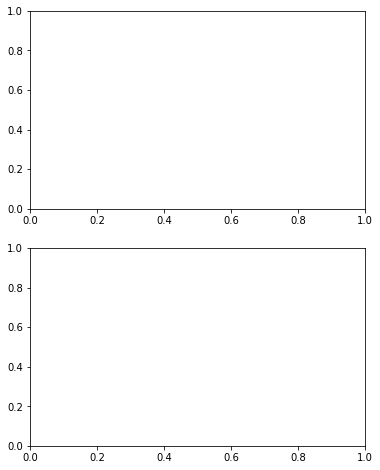

In [18]:
for idx in range(10):
    try:
        best_model.plot_interpretation(x, raw_predictions, idx=idx);
    except:
        break

In [28]:
actuals

tensor([[77800., 78000., 77100., 78100., 79400., 79900., 80500., 80200., 80300.,
         78800.],
        [78000., 77100., 78100., 79400., 79900., 80500., 80200., 80300., 78800.,
         78300.]])

In [29]:
predictions

tensor([[75822.0703, 75952.1250, 76057.2656, 76158.1562, 76270.2969, 76367.3125,
         76394.3594, 76318.1250, 76165.0625, 76007.6953],
        [76337.9531, 76746.0156, 77051.5469, 77122.4062, 76981.9531, 76781.1797,
         76685.4453, 76753.0938, 76888.9375, 76904.4609]])